In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import necessary libraries

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import datasets


Labels in dataset:
*   label 0: neutral
*   label 1: anti-vax
*   label 2: pro-vax







In [5]:
# train set
Train_set_Location = r'/content/vaccine_train_set.csv' 

# validation set
Validation_set_Location = r'/content/vaccine_validation_set.csv'  

df_train = pd.read_csv(Train_set_Location, index_col=0)
df_test = pd.read_csv(Validation_set_Location, index_col=0)

print(f"vaccine_validation_set: {df_train.shape}")
print(f"vaccine_train_set: {df_test.shape}")

df_train.head(10) # check the train dataframe

vaccine_validation_set: (15976, 2)
vaccine_train_set: (2282, 2)


,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0
5,Why did I get my whooping cough vaccine the sa...,2
6,Prosecutor Ken Ervin: I want to know how reckl...,0
7,"""@UberFacts: On average, people who complain l...",0
8,The legacy of @JennyMcCarthy will be she took ...,2
9,"“@UberFacts: On average, people who complain l...",0


# Clean up the data


In [6]:
# Drop the rows where at least one element is missing
df_train.dropna()
df_test.dropna()

df_train.head(5)

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


# Creating tensors with TF - IDF vectorizer

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1000)


tfidf_train = tfidf_vectorizer.fit_transform(df_train['tweet'])
tfidf_test = tfidf_vectorizer.transform(df_test['tweet'])
tfidf_train_test = tfidf_vectorizer.transform(df_train['tweet'])

In [8]:
# for train set
import scipy
import torch.nn as nn
import torch
from sklearn.preprocessing import LabelEncoder

#Converting the TF-IDF array to PyTorch tensor format.
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_train)).float()
# y_train = torch.tensor(df_train.label, dtype=torch.long)
# Encode the label for train set
le = LabelEncoder().fit(df_train.label)
Y_train = le.transform(df_train.label)
y_train = torch.tensor(Y_train)


print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: torch.Size([15976, 39])
y_train shape: torch.Size([15976])


In [9]:
# for test set
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_test)).float()
# y_test = torch.tensor(df_test.label, dtype=torch.long)
Y_test = le.transform(df_test.label)
y_test = torch.tensor(Y_test)

print(f"x_train shape: {x_test.shape}")
print(f"y_train shape: {y_test.shape}")

x_train shape: torch.Size([2282, 39])
y_train shape: torch.Size([2282])


# Creating data loaders

In [10]:
# Build data loaders
BatchSize = 1000

# Initialize train dataloader
dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BatchSize, shuffle=True)

# Initialize test dataloader
dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BatchSize, shuffle=True)

In [11]:
examples = iter(test_dataloader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([1000, 39]) torch.Size([1000])


# Creating Neural networks


## Neural network 1

In [12]:
import torch
import torch.nn as nn

# Testing the neural net work with tf idf represantation 
# I used the same model for the Glove represantation to compare them
class Network_1(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
      super(Network_1, self).__init__()
      self.linear1 = nn.Linear(input_size, hidden_size1)  
      self.relu1 = nn.ReLU()
      self.linear2 = nn.Linear(hidden_size1, hidden_size2)
      self.relu2 = nn.ReLU()
      self.linear3 = nn.Linear(hidden_size2, num_classes)


    def forward(self, x):
      out = self.linear1(x)
      out = self.relu1(out)
      out = self.linear2(out)
      out = self.relu2(out)
      out = self.linear3(out)
      return out 


In [13]:
# Creating the weights for the loss function 
import sklearn.utils.class_weight as class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train),y = y_train.numpy())
print('weights:', class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float)

weights: [0.71404309 2.56890175 0.8262736 ]


In [14]:
#Define layer sizes
input_size = x_train.shape[1]
hidden_size1 = 400
hidden_size2 = 300
num_classes = 3

#Define Hyperparameters
learning_rate = 1e-2

#Initialize model, loss, optimizer
model_1 = Network_1(input_size, hidden_size1, hidden_size2, num_classes)
# loss_func = nn.CrossEntropyLoss()
loss_func = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')


optimizer = torch.optim.Adamax(model_1.parameters(), lr=learning_rate)

model_1

Network_1(
  (linear1): Linear(in_features=39, out_features=400, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=400, out_features=300, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=300, out_features=3, bias=True)
)

### Training the Neural network 1

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score

num_epochs = 5
accuracies = []
average_f1_score = []
average_recall_score = []
average_precision_score = []

for epoch in range(num_epochs):
  train_losses = []
  test_losses = []
  

  for x_batch, y_batch in train_dataloader: # gia ato train set, to idio gia to validation sto project
    y_pred = model_1(x_batch)

    loss = loss_func(y_pred, y_batch) 

    train_losses.append(loss.item())
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

  print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {np.mean(train_losses):.4f}", end = '  ')
 
  # Testing the model_GloVe
  for x_batch, y_batch in test_dataloader:

    y_pred = model_1(x_batch)
    
    loss = loss_func(y_pred, y_batch) 

    ps = torch.exp(y_pred)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == y_batch.view(*top_class.shape)
    
    test_losses.append(loss.item())

    accuracy = torch.mean(equals.float())
    accuracies.append(accuracy)

  print(f"Test Loss = {np.mean(test_losses):.4f}", end = '  ')

  y_pred = model_1(x_test)

  # Getting precision, recall, f1 scores and accuracy.
  precision_score_temp = precision_score(y_test, torch.argmax(y_pred, dim=1), average='weighted')
  recall_score_temp = recall_score(y_test, torch.argmax(y_pred, dim=1), labels=[0, 1, 2], average='weighted')
  f1_score_temp = 2 * (precision_score_temp * recall_score_temp) / (precision_score_temp + recall_score_temp)


  average_precision_score.append(precision_score_temp)
  average_f1_score.append(f1_score_temp)
  average_recall_score.append(recall_score_temp)
  print("f1 score: {}%".format(round(f1_score_temp*100, 2)), end = '  ')
  print("precision score: {}%".format(round(precision_score_temp*100, 2)), end = '  ')
  print("recall score: {}%".format(round(recall_score_temp*100, 2)))

print()
print("Average accuracy: {} %".format(round(np.mean(accuracies)*100, 2)))
print("Average f1 score: {} %".format(round(np.mean(average_f1_score)*100, 2)))
print("Average recall score: {} %".format(round(np.mean(average_recall_score)*100, 2)))
print("Average precision score: {} %".format(round(np.mean(average_precision_score)*100, 2)))

Epoch 1/5: Train Loss = 0.9549  Test Loss = 0.8935  f1 score: 59.28%  precision score: 62.37%  recall score: 56.49%
Epoch 2/5: Train Loss = 0.8894  Test Loss = 0.8902  f1 score: 61.07%  precision score: 64.51%  recall score: 57.98%
Epoch 3/5: Train Loss = 0.8704  Test Loss = 0.8662  f1 score: 61.57%  precision score: 64.04%  recall score: 59.29%
Epoch 4/5: Train Loss = 0.8535  Test Loss = 0.8680  f1 score: 60.47%  precision score: 64.66%  recall score: 56.79%
Epoch 5/5: Train Loss = 0.8358  Test Loss = 0.8749  f1 score: 60.02%  precision score: 65.08%  recall score: 55.7%

Average accuracy: 57.55 %
Average f1 score: 60.48 %
Average recall score: 57.25 %
Average precision score: 64.13 %


## Neural network 2


In [22]:
import torch
import torch.nn as nn


class Network_2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
      super().__init__()
      self.linear1 = nn.Linear(input_size, hidden_size1)  
      self.celu = nn.CELU()
      self.linear2 = nn.Linear(hidden_size1, hidden_size2)
      self.gelu = nn.GELU()
      self.linear3 = nn.Linear(hidden_size2, hidden_size3)
      self.elu = nn.ELU()
      self.linear4 = nn.Linear(hidden_size3, num_classes)


    def forward(self, x):
      out = self.linear1(x)
      out = self.celu(out)
      out = self.linear2(out)
      out = self.gelu(out)
      out = self.linear3(out)
      out = self.elu(out)
      out = self.linear4(out)
      return out 


In [23]:
# Creating the weights for the loss function 
import sklearn.utils.class_weight as class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train),y = y_train.numpy())
print('weights:', class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float)

weights: [0.71404309 2.56890175 0.8262736 ]


In [27]:
#Define layer sizes
input_size = x_train.shape[1]
hidden_size1 = 20
hidden_size2 = 50
hidden_size3 = 35
num_classes = 3

#Define Hyperparameters
learning_rate = 3e-3

#Initialize model, loss, optimizer
model_2 = Network_2(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes)
# loss_func = nn.CrossEntropyLoss()
loss_func = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')


optimizer = torch.optim.Adamax(model_2.parameters(), lr=learning_rate)

model_2

Network_2(
  (linear1): Linear(in_features=39, out_features=20, bias=True)
  (celu): CELU(alpha=1.0)
  (linear2): Linear(in_features=20, out_features=50, bias=True)
  (gelu): GELU()
  (linear3): Linear(in_features=50, out_features=35, bias=True)
  (elu): ELU(alpha=1.0)
  (linear4): Linear(in_features=35, out_features=3, bias=True)
)

### Training the Neural network 2 

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score

num_epochs = 15
accuracies = []
average_f1_score = []
average_recall_score = []
average_precision_score = []

average_train_losses = [] # for ploting
average_test_losses = []

# predictions = torch.empty(len(y_test))

for epoch in range(num_epochs):
  curr_train_losses = []
  curr_test_losses = []
  f1_scores = []
  precision_scores = []
  recall_scores = []
  

  for x_batch, y_batch in train_dataloader: # gia ato train set, to idio gia to validation sto project
    y_pred = model_2(x_batch)

    loss = loss_func(y_pred, y_batch) 

    curr_train_losses.append(loss.item())
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

  mean_train_losses = np.mean(curr_train_losses)
  print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {mean_train_losses:.4f}", end = '  ')

  average_train_losses.append(mean_train_losses)

  # for test loop
  # with torch.no_grad():
  for x_batch, y_batch in test_dataloader:

    y_pred = model_2(x_batch)
    
    loss = loss_func(y_pred, y_batch) # convert to type long
    
    curr_test_losses.append(loss.item())

    
    accuracy = torch.mean(equals.float())
    accuracies.append(accuracy)

  mean_test_losses = np.mean(curr_test_losses)
  print(f"Test Loss = {mean_test_losses:.4f}", end = '  ')

  average_test_losses.append(mean_test_losses)

  # Test the scores for the model
  y_pred = model_2(x_test)

  ps = torch.exp(y_pred)
  top_p, top_class = ps.topk(1, dim=1)
  equals = top_class == y_test.view(*top_class.shape)
  # predictions = top_class

  # Getting precision, recall, f1 scores and accuracy.
  precision_score_temp = precision_score(y_test, torch.argmax(y_pred, dim=1), average='weighted')
  recall_score_temp = recall_score(y_test, torch.argmax(y_pred, dim=1), labels=[0, 1, 2], average='weighted')
  f1_score_temp = 2 * (precision_score_temp * recall_score_temp) / (precision_score_temp + recall_score_temp)

  average_precision_score.append(precision_score_temp)
  average_f1_score.append(f1_score_temp)
  average_recall_score.append(recall_score_temp)
  print("f1 score: {}%".format(round(f1_score_temp*100, 2)), end = '  ')
  print("precision score: {}%".format(round(precision_score_temp*100, 2)), end = '  ')
  print("recall score: {}%".format(round(recall_score_temp*100, 2)))

print()
print("Average accuracy: {} %".format(round(np.mean(accuracies)*100, 2)))
print("Average f1 score: {} %".format(round(np.mean(average_f1_score)*100, 2)))
print("Average recall score: {} %".format(round(np.mean(average_recall_score)*100, 2)))
print("Average precision score: {} %".format(round(np.mean(average_precision_score)*100, 2)))

Epoch 1/15: Train Loss = 1.0925  Test Loss = 1.0794  f1 score: 53.77%  precision score: 66.68%  recall score: 45.05%
Epoch 2/15: Train Loss = 1.0606  Test Loss = 1.0296  f1 score: 54.4%  precision score: 61.15%  recall score: 48.99%
Epoch 3/15: Train Loss = 0.9985  Test Loss = 0.9614  f1 score: 56.14%  precision score: 61.83%  recall score: 51.4%
Epoch 4/15: Train Loss = 0.9457  Test Loss = 0.9055  f1 score: 58.01%  precision score: 62.21%  recall score: 54.34%
Epoch 5/15: Train Loss = 0.9204  Test Loss = 0.9111  f1 score: 58.66%  precision score: 61.91%  recall score: 55.74%
Epoch 6/15: Train Loss = 0.9124  Test Loss = 0.9046  f1 score: 58.26%  precision score: 63.5%  recall score: 53.81%
Epoch 7/15: Train Loss = 0.9099  Test Loss = 0.8954  f1 score: 58.01%  precision score: 62.74%  recall score: 53.94%
Epoch 8/15: Train Loss = 0.9078  Test Loss = 0.8972  f1 score: 59.04%  precision score: 63.21%  recall score: 55.39%
Epoch 9/15: Train Loss = 0.9065  Test Loss = 0.9028  f1 score: 59.1

### Plot loss vs epoch

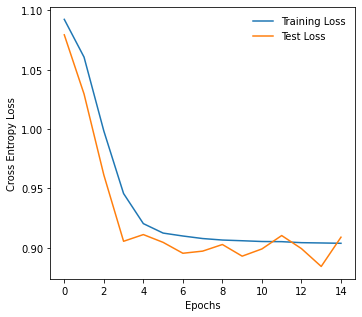

In [29]:
#Plotting loss vs epochs.
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)

plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')

plt.plot(average_train_losses, label='Training Loss')
plt.plot(average_test_losses, label='Test Loss')
plt.legend(frameon=False);

### Plotting ROC curve for multi-class
https://scikit-learn.org/0.15/auto_examples/plot_roc.html

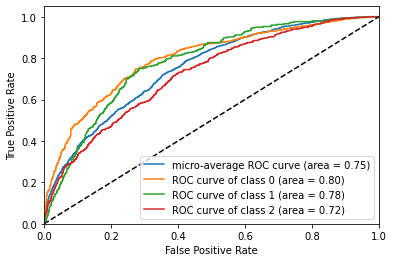

In [30]:
from torch.autograd import Variable
from sklearn.metrics import roc_curve,auc
predictions = model_2(x_test)

# binarize the the labels
y_test_roc = []
for pred in y_test:
  if pred == 0:
    y_test_roc.append([1, 0, 0])
  elif pred == 1:
    y_test_roc.append([0, 1, 0])
  elif pred == 2:
    y_test_roc.append([0, 0, 1])


n_classes = 3

predictions = Variable(predictions, requires_grad=True)
predictions = predictions.detach().numpy()
y_test_roc = np.array(y_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Getting scores from softmax regression from Homework 1.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# targets
train_label = np.asarray(df_train['label'])
test_label = np.asarray(df_test['label'])

# Prepare the model
model_LR = LogisticRegression(multi_class='multinomial', max_iter=10000)
model_LR.fit(tfidf_train, train_label)
y_test_pred = model_LR.predict(tfidf_test)

#The classification report will give us the scores for precision, recall and F1 metrics.
print(classification_report(test_label, y_test_pred))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72      1065
           1       0.42      0.06      0.11       296
           2       0.56      0.66      0.60       921

    accuracy                           0.62      2282
   macro avg       0.56      0.49      0.48      2282
weighted avg       0.60      0.62      0.59      2282

